In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics.cluster import homogeneity_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, append=True)

In [2]:
def visualize_embeddings_tSNE(emb_matrix, word_types):
    print("Running tSNE on", emb_matrix.shape, "-dim data")
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250)
    tsne_results = tsne.fit_transform(emb_matrix)
    print('t-SNE done!')
    df_tsne = {'word_type': word_types}
    df_tsne['ax1'] = tsne_results[:, 0]
    df_tsne['ax2'] = tsne_results[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_tsne,
                     x='ax1',
                     y='ax2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_layout(legend=dict(font=dict(size=10)))
    fig.show()

In [3]:
def visualize_embeddings_PCA(emb_matrix, word_types):
    print("Running PCA on", emb_matrix.shape, "-dim matrix")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(emb_matrix)
    df_pca = {'word_type': word_types}
    df_pca['PC1'] = pca_result[:, 0]
    df_pca['PC2'] = pca_result[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_pca,
                     x='PC1',
                     y='PC2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.show()

In [4]:
tasks = ['P', 'PC', 'PCT', 'PT']

df = pd.read_csv("concreteness_norms_input_embs_multitask.csv")

df["task"] = [m.split("/")[0] for m in df.model.tolist()]
df["task"].replace(to_replace="paraphrase", value="P", inplace=True)
df["task"].replace(to_replace="paraphrase-captioning", value="PC", inplace=True)
df["task"].replace(to_replace="paraphrase-captioning-translation", value="PCT", inplace=True)
df["task"].replace(to_replace="paraphrase-translation", value="PT", inplace=True)
df.task.value_counts()

task
P      80000
PC     80000
PCT    80000
PT     80000
Name: count, dtype: int64

In [5]:
# KMeans clustering
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

def compute_purity(data):
    emb_matrix = np.array(data.iloc[:,:512])
    true_labels = data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

def compute_purity_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

task_purity = {'task':[], 
               'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity['purity'].extend(model_purity.tolist())
    task_purity['task'].extend([task]*len(model_purity))

Task: P
mean: 0.7585125
std: 0.02939834451557452
Task: PC
mean: 0.7632125000000001
std: 0.03311651681408291
Task: PCT
mean: 0.7692875000000001
std: 0.024969182929239914
Task: PT
mean: 0.7577999999999999
std: 0.021491143077305836


<AxesSubplot:xlabel='task', ylabel='purity'>

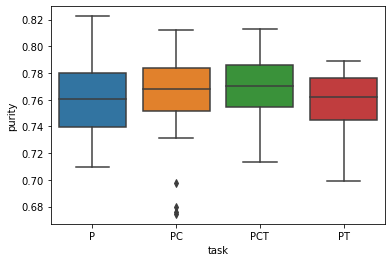

In [7]:
import seaborn as sns
task_purity = pd.DataFrame.from_dict(task_purity)
sns.boxplot(data=task_purity, x="task", y="purity")

In [8]:
from scipy.stats import kruskal
P_purity = task_purity[task_purity.task == 'P'].purity.to_list()
PC_purity = task_purity[task_purity.task == 'PC'].purity.to_list()
PCT_purity = task_purity[task_purity.task == 'PCT'].purity.to_list()
PT_purity = task_purity[task_purity.task == 'PT'].purity.to_list()
print("P vs PC:", kruskal(P_purity, PC_purity))
print("P vs PCT:", kruskal(P_purity, PCT_purity))
print("P vs PT:", kruskal(P_purity, PT_purity))
print("PC vs PT:", kruskal(PC_purity, PCT_purity))
print("PC vs PCT:", kruskal(PC_purity, PCT_purity))
print("PCT vs PT:", kruskal(PCT_purity, PT_purity))

P vs PC: KruskalResult(statistic=0.8182632343977035, pvalue=0.3656884450669554)
P vs PCT: KruskalResult(statistic=2.7080395765682153, pvalue=0.09984362176608595)
P vs PT: KruskalResult(statistic=0.016878758748430887, pvalue=0.8966310837373759)
PC vs PT: KruskalResult(statistic=0.5002962897837028, pvalue=0.47936996395858544)
PC vs PCT: KruskalResult(statistic=0.5002962897837028, pvalue=0.47936996395858544)
PCT vs PT: KruskalResult(statistic=3.2040844079718496, pvalue=0.07345461156244334)


In [9]:
def compute_silhouette_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(word_type_counts['abstract'])
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    return metrics.silhouette_score(emb_matrix, true_labels)

task_sil = {'task':[], 
               'sil':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_sil = task_models.groupby("model").apply(lambda x: compute_silhouette_balance_data(x))
    print('mean:', model_sil.mean())
    print('std:', model_sil.std())
    task_sil['sil'].extend(model_sil.tolist())
    task_sil['task'].extend([task]*len(model_sil))

Task: P
mean: 0.023654408403729277
std: 0.004162342348287263
Task: PC
mean: 0.024984368857601757
std: 0.004065684335508264
Task: PCT
mean: 0.02706743998147505
std: 0.0040861536273823695
Task: PT
mean: 0.0246020691798487
std: 0.004476688666628802


In [10]:
from scipy.stats import kruskal
task_sil = pd.DataFrame.from_dict(task_sil)
P_sil = task_sil[task_sil.task == 'P'].sil.to_list()
PC_sil = task_sil[task_sil.task == 'PC'].sil.to_list()
PCT_sil = task_sil[task_sil.task == 'PCT'].sil.to_list()
PT_sil = task_sil[task_sil.task == 'PT'].sil.to_list()
print("P vs PC:", kruskal(P_sil, PC_sil))
print("P vs PCT:", kruskal(P_sil, PCT_sil))
print("P vs PT:", kruskal(P_sil, PT_sil))
print("PC vs PCT:", kruskal(PC_sil, PCT_sil))
print("PC vs PT:", kruskal(PC_sil, PT_sil))
print("PCT vs PT:", kruskal(PCT_sil, PT_sil))

P vs PC: KruskalResult(statistic=2.000833333333361, pvalue=0.15721275333999682)
P vs PCT: KruskalResult(statistic=12.74453703703702, pvalue=0.0003570505108266695)
P vs PT: KruskalResult(statistic=0.8008333333333724, pvalue=0.3708443333042094)
PC vs PCT: KruskalResult(statistic=4.813333333333361, pvalue=0.028240368733300086)
PC vs PT: KruskalResult(statistic=0.4408333333333303, pvalue=0.5067205148778597)
PCT vs PT: KruskalResult(statistic=7.5737037037037, pvalue=0.005922595857839187)


In [12]:
# Affinity propagation clustering
def compute_purity_balance_data_aff_prop(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    aff_prop = AffinityPropagation().fit(emb_matrix)
    y_pred = aff_prop.labels_
    purity = purity_score(true_labels, y_pred)
    return purity

task_purity_aff_prop = {'task':[], 
                        'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data_aff_prop(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity_aff_prop['purity'].extend(model_purity.tolist())
    task_purity_aff_prop['task'].extend([task]*len(model_purity))

Task: P


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propaga

mean: 0.757625
std: 0.017654355894545743
Task: PC


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propaga

mean: 0.753225
std: 0.02216168731426794
Task: PCT


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.7654249999999999
std: 0.016685073169353103
Task: PT


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.7540125
std: 0.019297431574813662


In [13]:
from scipy.stats import kruskal
task_purity_aff_prop = pd.DataFrame.from_dict(task_purity_aff_prop)
P_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'P'].purity.to_list()
PC_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PC'].purity.to_list()
PCT_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PCT'].purity.to_list()
PT_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PT'].purity.to_list()
print("P vs PC:", kruskal(P_purity, PC_purity))
print("P vs PCT:", kruskal(P_purity, PCT_purity))
print("P vs PT:", kruskal(P_purity, PT_purity))
print("PC vs PCT:", kruskal(PC_purity, PCT_purity))
print("PC vs PT:", kruskal(PC_purity, PT_purity))
print("PCT vs PT:", kruskal(PCT_purity, PT_purity))

P vs PC: KruskalResult(statistic=0.9265666600204058, pvalue=0.33575666836174367)
P vs PCT: KruskalResult(statistic=4.6908537515101045, pvalue=0.030323577086454726)
P vs PT: KruskalResult(statistic=0.5708998850736314, pvalue=0.449901547475806)
PC vs PCT: KruskalResult(statistic=6.602613222035967, pvalue=0.010182920759237593)
PC vs PT: KruskalResult(statistic=0.03705267107546656, pvalue=0.8473578489950951)
PCT vs PT: KruskalResult(statistic=6.094160667385786, pvalue=0.013562933579439574)


In [16]:
# Agglomerative (hierarchical) clustering
def compute_purity_balance_data_agglomerative(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    agg = AgglomerativeClustering(n_clusters=None,
                                  metric='cosine',
                                  linkage='average',
                                 distance_threshold=0.5).fit(emb_matrix)
    y_pred = agg.labels_
    print('leaves:', agg.n_leaves_)
    purity = purity_score(true_labels, y_pred)
    return purity

task_purity_agg = {'task':[], 
                   'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data_agglomerative(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity_agg['purity'].extend(model_purity.tolist())
    task_purity_agg['task'].extend([task]*len(model_purity))

Task: P
leaves: 2000
leaves: 2000
leaves: 2000
leaves: 2000
leaves: 2000


KeyboardInterrupt: 